In [1]:
# %load http://che.byu.edu/imports.py
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize      import fsolve, curve_fit
from scipy.integrate     import odeint, quad
from scipy.interpolate   import interp1d
from scipy.misc          import derivative
import scipy.constants   as const
import sympy             as sp
sp.init_printing()
import glob
import time
from scipy.optimize import minimize
import pandas as pd

import scipy as sp
import solarsystem as ss
import datetime
pi = 3.14159265359
import math

#FOR ANIMATION
import matplotlib.animation as animation
from datetime import datetime, timezone
from termcolor import colored

### PARAMETERS

In [2]:
#PARAMETERS
mass = {'Mercury':3.285*10**23,
'Venus':4.867*10**24,
'Earth': 5.972*10**24,
'Mars': 6.39*10**23,
'Jupiter': 1.898*10**27,
'Saturn':  5.683*10**26,  
'Uranus': 8.681*10**25,  
'Neptune':1.024*10**26,    
'Pluto':0.01303*10**24,    
'Ceres':9.1*10**20, 
'Chiron':4*10**17, 
'Eris':1.6466*10**22,
'Sun':1.989*10**30,
'Rocket':1000}                          #kg

radius = {'Mercury':4878/2,
'Venus':12104/2,
'Earth':12756/2,
'Mars':6794/2,
'Jupiter':142984/2,
'Saturn':120536/2,  
'Uranus':51118/2,  
'Neptune':49532,    
'Pluto':1188,    
'Ceres':473, 
'Chiron':135, 
'Eris':1163,
'Sun':6963,
'Rocket':0.002}                        #km

c = 299792458                         #m/s
G  = 6.674*10**-11                    #Nm^2/kg^2
F = 0.83                             #newtons of force  original value was 83E-3

### COLLISION

In [3]:
#COLLISION FUNCTION
def collision(px,py):
    Return = 0
    for i, planet in enumerate(names,0):
        if planet=='Rocket':
            continue
        dx = px[i][-1]-px[-1][-1]
        dy = py[i][-1]-py[-1][-1]
        d  = (dx**2+dy**2)**0.5
        if d<radius[planet]:
            print(f'Rocket collided with the planet {planet}')
            Return = 1
            break
        else:
            Return = 0
            
    return Return 

### POSITION TRACKER

In [4]:
#base: the planet the rocket will be starting near
#t_0: The time at which we are giving the location
#the function is given the base planet and will compute

def position_tracker(destination_base,t_0,t_plus, x_off_set,y_off_set):
   
    #FINDING THE INITIAL RADIUS AND LONGITUDE RELATIVE TO THE SUN
    px    = movement(t_0,0)[destination_base]['x']+x_off_set
    py    = movement(t_0,0)[destination_base]['y']+y_off_set
    r     = (px**2+py**2)**0.5
    θ  = np.arctan(py/px)*180/pi

    #FINDING DR AND D θ relative to the planet
    θ_planet = movement(t0,0,cylindrical=True)[destination_base][0]
    r_planet = movement(t0,0,cylindrical=True)[destination_base][1]
    dr = r-r_planet
    dθ = θ-θ_planet
    
    #FINDING THE X AND Y AT TIME T_PLUS
    if t_plus>0:
        θ_planet = movement(t0,t_plus,cylindrical=True)[destination_base][0]
        r_planet = movement(t0,t_plus,cylindrical=True)[destination_base][1]
        θ        = θ_planet+dθ  #the cyl coordinate relative to the sun
        r        = r_planet+dr
    
    #CONVERTING THE R AND θ BACK TO XY
    θ = θ*pi/180
    x = np.cos(θ)*r
    y = np.sin(θ)*r
    return x,y

### MOVEMENT

In [5]:

#MOVEME3NT OF CELESTIAL OBJECTS
#COLLECTING XYZ POSITIONS AND VELOCITIES FOR ALL CELESTIAL OBJECTS
def movement(t0,t_plus=0,print=False, cylindrical=False):
    #TIME
    time = datetime.fromtimestamp(t0+t_plus)
    year   = time.year
    month  = time.month
    day    = time.day
    hour   = time.hour
    minute = time.minute

    UT                 = 0
    dst                = 0 
    view               ='horizontal'
    H                  = ss.Heliocentric(year=year, month=month, day=day, hour=hour, minute=minute,UT=UT, dst=dst, view=view )
    celestial_object   = H.planets()
    distances          = []
    dict               = {}
    if print==True:
        print('Planet', '   \t','Longitude', '  \t','Latitude', '   \t','Distance')
        print('-------------------------------------------------------------------')

    for key in celestial_object:
        distances.append(celestial_object[key][2])
        elements = celestial_object[key]
        dict[key] = [elements[0],elements[1],elements[2]*1.496E8]
        if print==True:
            print(key, '   \t',round(elements[0],2), '  \t',round(elements[1],2), '   \t',round(elements[2]*1.496E8,2))
    if print==True:
        print()
        print('Distance in m')

    #CONVERTING TO XY PLANE
    dict_xyz = {}
    for key in dict:
        #READING THE HORIZONTAL DATA 
        longitude,latitude,distance = dict[key] 

        #X AND Y ACCORDING TO THE QUADRANT
        if 90>longitude>=0:  #QUADRANT I
            θ = longitude*pi/180
            x = np.cos(θ)*distance
            y = np.sin(θ)*distance

        if 180>longitude>=90:  #QUADRANT II
            θ = pi-longitude*pi/180
            x = -np.cos(θ)*distance
            y = np.sin(θ)*distance

        if 270>longitude>=180:  #QUADRANT III
            θ = longitude*pi/180-pi
            x = -np.cos(θ)*distance
            y = -np.sin(θ)*distance

        if 360>longitude>=270: #QUADRANT IV
            θ = 2*pi-longitude*pi/180
            x = np.cos(θ)*distance
            y = -np.sin(θ)*distance

        #FINDING THE Z COORDINATE
        if np.abs(latitude)!=latitude:
            θ = np.abs(latitude)*pi/180
            z = -np.sin(θ)*distance

        if 270<latitude<360:
            θ = 2*pi-latitude*pi/180
            z = -np.sin(θ)*distance

        if 0<latitude<90:
            θ = latitude*pi/180
            z = np.sin(θ)*distance

        #SAVING DATA TO DICT XYZ
        dict_inner    = {'x':x,'y':y,'z':z}
        dict_xyz[key] = dict_inner       #distance in kilometers
    #ADDING THE POSITION OF THE SUN
    dict_xyz['Sun'] = {'x':0,'y':0,'z':0}
    if cylindrical==False:
        Return = dict_xyz
    if cylindrical==True:
        Return = dict
    return Return

### FORCE BALANCE 

In [6]:
#this determines the necessary Fxthrust and Fy thrust to head straight towards our destination
def Fbalance(xnow,ynow,xtarget,ytarget,Fxparasite,Fyparasite):
    #Feffective
    xl    = xtarget-xnow                                     #distance in x to destination
    yl    = ytarget-ynow                                     #distance in y to destination
    
    def solver(X):
        Fxt,Fyt = X
        Fxe,Fye = (Fxparasite+Fxt),(Fyparasite+Fyt)
        EQ1     = yl*Fxe-xl*Fye
        EQ2     = F-(Fxe**2+Fye**2)**0.5
        return EQ1,EQ2
    
    guessx,guessy = 0,0
    guessx = np.sign(np.array(xl))
    guessy = np.sign(np.array(yl))
    

    Fxthrust,Fythrust =fsolve(solver,(guessx,guessy))
    
    H_desired = (Fxthrust+Fxparasite),(Fythrust+Fyparasite)
    
    return Fxthrust,Fythrust,H_desired

### FOPDT FUNCTION

In [7]:
#H_desired_prev is the vector [Fxnet,Fynet]
#H_des_prev is the angle version of H_desired_prev
#H_act_prev is the heading according to the last two positions
#H_a is the adjustment to the heading (H_rocket = H_a+H(from F balance))

def F_adjust(H_desired_prev,H_act_prev,H_adj_p,kp,τ,θ,dt):  #for now ignore theta
    
    H_des_prev    = np.arctan(H_desired_prev[1]/H_desired_prev[0])*180/pi
    H_actual_prev = np.arctan(H_act_prev[1]/H_act_prev[0])*180/pi
    H_adj = (kp*(H_des_prev-H_actual_prev)-H_actual_prev*τ/dt)*dt/(1-τ)
    
    def solver(X):
        dFx,dFy = X
        eq1 = (dFx**2+dFy**2)**0.5
        eq2 = np.arctan(dFy/dFx)-H_adj
        return eq1,eq2
    
    #creating guess values
    errorx = H_desired_prev[0]-H_act_prev[0]
    errory = H_desired_prev[1]-H_act_prev[1]
    gx = np.sign(np.array(errorx))
    gy = np.sign(np.array(errory))
    
    dFx,dFy = fsolve(solver, (gx,gy))
    
    return dFx,dFy,H_adj

### SIMULATOR

In [8]:
    #SIMULATOR
    #UNITS
'''KILOMETERS, KG, SECONDS'''
#PARAMETERS
names = ['Earth','Venus','Mercury', 'Mars','Ceres','Jupiter','Rocket']          #!!! make rocket the last in the list
Mass = np.zeros(len(names))
for i,p in enumerate(names,0):Mass[i] = mass[p]  
G  = (6.674*10**-11)*(1/1000)**3                        #Nkm^2/kg^2  N = kg*km/s**2
    
#TIME ARRAY
dt = 60   #seconds
start = time.time()

'''POSITION VARIABLES'''
px = []
py = []

'''VELOCITY VARIABLES'''
vx_rocket = []
vy_rocket = []

'''ACCELERATION VARIABLES'''
ax_rocket = []
ay_rocket = []

'''FORCE VARIABLES'''
fx_rocket = []
fy_rocket = []

'''FORCE MOTOR'''
fx_motor  = []
fy_motor  = []

'''PARASITE FORCE'''
Fxparasite = []
Fyparasite = []

'''COUNTING'''
counter     = []
time_array  = []
d_store     = []
dt_store    = []
Hadj_store  = []
H_act_prev  = []
Fxa_store   = []
Fya_store   = []
H_desired_store = []
flight_time = 0
t0          = time.time()
time_array.append(time.time())


'''NOISE'''
Fxnoise = np.random.normal(1,0.0001,10**8)
Fynoise = np.random.normal(1,0.0001,10**8)

###############################################
'''THE FUNCTION'''
    def function(x_rocket_0,y_rocket_0,x_off_set,y_off_set,t_start = time.time(),base='Earth',destination_base = 'Mars', planetary_movement='False',
                Kp=1,τ=10):
        '''RESETING ARRAYS'''    
        px.clear()
        py.clear()
        vx_rocket.clear()
        vy_rocket.clear()
        ax_rocket.clear()
        ay_rocket.clear()
        fx_rocket.clear()
        fy_rocket.clear()    
        d_store.clear()
        dt_store.clear()
        
        '''APPENDING INITIAL DATA'''
        '''POSITIONS'''
        px_now = movement(t_start,0)
        for i in range(len(names)): px.append([]),py.append([])
        for i,planet in enumerate(names,0): 
            if planet=='Rocket':
                px[i].append(x_rocket_0+px_now[base]['x']),py[i].append(y_rocket_0+px_now[base]['y'])
                continue
            px[i].append(px_now[planet]['x']),py[i].append(px_now[planet]['y'])

    
        '''VELOCITIES'''
        vx_rocket.append(0)
        vy_rocket.append(0)
    
        '''ACCELERATION'''
        ax_rocket.append(0)
        ay_rocket.append(0)
    
        '''FORCE'''
        fx_rocket.append(0)
        fy_rocket.append(0)
        
        '''PARASITE FORCE'''
        sum_forcex = 0
        xrocket0 = px[-1]
        for num,x2 in enumerate(px,0):
            if names[i]=='Rocket':
                continue
            if xrocket0[t]>x2:
                sign1x = -1
                sign2x = 1
            else:
                sign1x = 1
                sign2x = -1     
            if names[num]!='Rocket':
                sum_forcex+=G*mass['Rocket']*Mass[num]/(xrocket0-x2[0])**2*sign1x
        Fxparasite.append(sum_forcex)
        
        sum_forcey = 0
        yrocket0 = py[-1]
        for num,y2 in enumerate(py,0):
            if names[i]=='Rocket':
                continue
            if yrocket0[t]>y2:
                sign1y = -1
                sign2y = 1
            else:
                sign1y = 1
                sign2y = -1     
            if names[num]!='Rocket':
                sum_forcey+=G*mass['Rocket']*Mass[num]/(yrocket0-y2[0])**2*sign1y
        Fyparasite.append(sum_forcey)
    

        '''INITIALIZING THE DISTANCE AND TIME'''
        x_target,y_target = position_tracker(destination_base,t_start,0, x_off_set,y_off_set)
        dx =x_target-px[-1][0] 
        dy =y_target-py[-1][0]
        distance = (dx**2+dy**2)**0.5
        distance0=distance
        t =0
        flight_time = 0
        A = 0
    
     ###################################   
    
        '''START THE WHILE LOOP'''
        while distance>250000 and A==0:               #km
            #code to decrease dt if we are predicted to arrive in the next 
            
            
            '''FINDING THE HEADING TO THE TARGET'''
                        
            if planetary_movement=='False':
                xtarget,ytarget = position_tracker(destination_base,t_start,0, x_off_set,y_off_set)
                fxthrust,fythrust,H_desired = Fbalance(px[-1][t],py[-1][t],xtarget,ytarget,Fxparasite[t],Fyparasite[t])
            if planetary_movement=='True':
                xtarget,ytarget = position_tracker(destination_base,t_start,t, x_off_set,y_off_set)
                fxthrust,fythrust,H_desired = Fbalance(px[-1][t],py[-1][t],xtarget,ytarget,Fxparasite[t],Fyparasite[t])
            
            '''FOPDT FORCE ADJUSTMENT'''
            H_desired_store.append(H_desired)
            if t>3:        
                H_act_prev.append([(ax_rocket[-2]-ax_rocket[-1])/mass['Rocket']
                               ,(ay_rocket[-2]-ay_rocket[-1])/mass['Rocket']])
            if t<5:
                Hadj = 0
                Fxa,Fya = 0,0
            if t>=5:
                #Kp = 1
                #τ  = 1
                θ  = 0    
                Fxa,Fya,Hadj = F_adjust(H_desired,H_act_prev[-1],Hadj_store[-1],Kp,τ,θ,dt)
            Fxa_store.append(Fxa)
            Fya_store.append(Fya)
            Hadj_store.append(Hadj)
            
            
            '''PLANETARY MOVEMENT'''
            if planetary_movement=='False':
                xyz_planet = movement(t0,0)
            if planetary_movement=='True':
                xyz_planet = movement(t0,t)
                
                
            '''FINDING PLANET PX & ROCKET FORCE'''
            for i,x1 in enumerate(px,0):
                sum_force = 0               #only for the rocket
                if names[i]=='Rocket':
                    for j,x2 in enumerate(px,0):
                        if x1[t]>x2[t]:
                            sign1x = -1
                            sign2x = 1
                        else:
                            sign1x = 1
                            sign2x = -1     
                        if names[j]!='Rocket':
                            sum_force+=G*Mass[i]*Mass[j]/(x1[t]-x2[t])**2*sign1x
                    Fxparasite.append(sum_force)
                    #sum_force*=Fxnoise[t]
                    sum_force+=fxthrust #+Fxa
                    fx_motor.append(fxthrust+Fxa)
                    fx_rocket.append(sum_force)
                    continue    
                x1.append(xyz_planet[names[i]]['x'])
           
            '''ACCELERATION X'''
            ax_rocket.append(fx_rocket[-1]/mass['Rocket'])    #km/s^2

            '''VELOCITY X'''
            vx_rocket.append(vx_rocket[-1]+ax_rocket[-1]*dt)    #km/s
            
            '''POSITION X'''
            px[-1].append(px[-1][-1]+vx_rocket[t]*dt)          #km from origin           
            
            
            ''' Y AXIS'''        
            '''FINDING PLANET PY'''
            for i,y1 in enumerate(py,0):
                sum_force = 0               #only for the rocket
                if names[i]=='Rocket':
                    for j,y2 in enumerate(py,0):
                        if y1[t]>y2[t]:
                            sign1y = -1
                            sign2y = 1
                        else:
                            sign1y = 1
                            sign2y = -1     
                        if names[j]!='Rocket':
                            sum_force+=G*Mass[i]*Mass[j]/(y1[t]-y2[t])**2*sign1y
                    Fyparasite.append(sum_force)
                    #sum_force*=Fynoise[i]
                    sum_force+=fythrust #+Fya
                    fy_motor.append(fythrust+Fya)
                    fy_rocket.append(sum_force)
                    continue            
                y1.append(xyz_planet[names[i]]['y'])
                    
            '''ACCELERATION Y'''
            ay_rocket.append(fy_rocket[-1]/mass['Rocket'])    #km/s^2

            '''VELOCITY Y'''
            vy_rocket.append(vy_rocket[-1]+ay_rocket[t]*dt)    #km/s
            
            '''POSITION Y'''
            py[-1].append(py[-1][-1]+vy_rocket[-1]*dt)          #km from origin
           
            '''BREAKING IF ROCKET HITS THE ATMOSPHER'''
            A = collision(px,py)        
            
            '''DISTANCE'''
            dx =x_target-px[-1][-1] 
            dy =y_target-py[-1][-1]
            distance = (dx**2+dy**2)**0.5
            d_store.append(distance)
            
            '''RUN AWAY DISTANCE'''
            if np.abs(distance)>6*10**9:
                print('Rocket left solar system')
                break
            
            '''TIMER'''
            print_freq = 1000
            if t%print_freq==0:
                if t<3:
                    print(f'Distance Remaining:{np.around(distance)} of {np.around(distance0)} km')
                if t>=3:
                    if d_store[-1]<=d_store[-2]:
                        print(colored(f'Distance Remaining:{np.around(distance,0)} of {np.around(distance0,0)} km', 'green'))    
                    if d_store[-1]>d_store[-2]:
                        print(colored(f'Distance Remaining:{np.around(distance,0)} of {np.around(distance0,0)} km', 'red'))
                time_array.append(time.time())
                print(f"Computation time for {print_freq}" ," {:.{}f}".format(time_array[-1]-time_array[-2], 3 ))
                #print('ETA = ', round((100-sum(counter))*(time_array[-1]-time_array[0])/sum(counter),2))
            t +=1 
            #dt_store.append(dt)
            '''FLIGHT TIME'''
            flight_time = dt*t

  
        '''PRINTING COMP TIME'''    
        end = time.time()
        #print(f'Computation time = ', round((end-start),2))
        print('Flight Time =', flight_time)
        print()
        return flight_time
#tell the optimizer which angles cause ss abondonment 

### CALLER

In [9]:
start = time.time()
x_rocket_0 = 100000
y_rocket_0 = 100000
x_off_set  = 1000000000
y_off_set  = 1000000000
function(x_rocket_0,y_rocket_0,x_off_set,y_off_set,base='Earth',
         destination_base='Earth')
end = time.time()
print("Computation time = {:.{}f}".format( end-start, 0 ))

Distance Remaining:1414072141.0 of 1414072141.0 km
Computation time for 1000  5.879


C:\Users\Josh\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Distance Remaining:1412576696.0 of 1414072141.0 km
Computation time for 1000  1.589
Distance Remaining:1408093202.0 of 1414072141.0 km
Computation time for 1000  1.530
Distance Remaining:1400621708.0 of 1414072141.0 km
Computation time for 1000  1.400
Distance Remaining:1390162214.0 of 1414072141.0 km
Computation time for 1000  1.368
Distance Remaining:1376714698.0 of 1414072141.0 km
Computation time for 1000  1.471
Distance Remaining:1360279204.0 of 1414072141.0 km
Computation time for 1000  1.523
Distance Remaining:1340855710.0 of 1414072141.0 km
Computation time for 1000  1.407
Distance Remaining:1318444216.0 of 1414072141.0 km
Computation time for 1000  1.580


C:\Users\Josh\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Distance Remaining:1293044722.0 of 1414072141.0 km
Computation time for 1000  1.454
Distance Remaining:1264657227.0 of 1414072141.0 km
Computation time for 1000  1.457
Distance Remaining:1233281733.0 of 1414072141.0 km
Computation time for 1000  1.327
Distance Remaining:1198918217.0 of 1414072141.0 km
Computation time for 1000  1.310
Distance Remaining:1161566723.0 of 1414072141.0 km
Computation time for 1000  1.446
Distance Remaining:1121227229.0 of 1414072141.0 km
Computation time for 1000  1.405
Distance Remaining:1077899718.0 of 1414072141.0 km
Computation time for 1000  1.515
Distance Remaining:1031584224.0 of 1414072141.0 km
Computation time for 1000  1.468
Distance Remaining:982280725.0 of 1414072141.0 km
Computation time for 1000  1.559
Distance Remaining:929989231.0 of 1414072141.0 km
Computation time for 1000  1.689
Distance Remaining:874709737.0 of 1414072141.0 km
Computation time for 1000  1.380
Distance Remaining:816442243.0 of 1414072141.0 km
Computation time for 1000  1.

<ipython-input-7-b5db76203f9f>:15: RuntimeWarning: divide by zero encountered in double_scalars
  eq2 = np.arctan(dFy/dFx)-H_adj


### PLOTTING

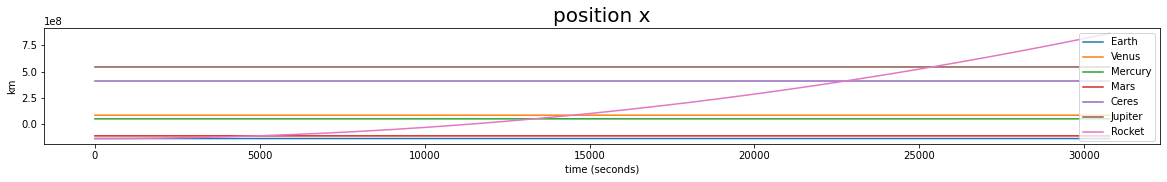

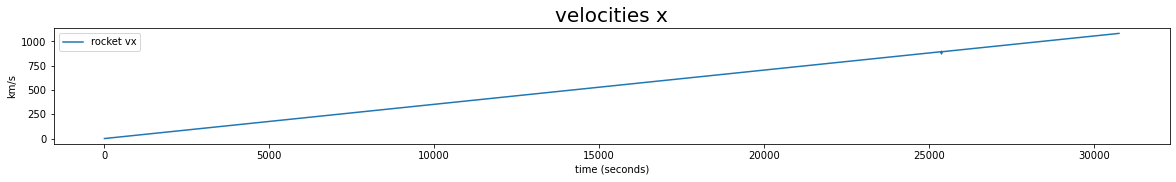

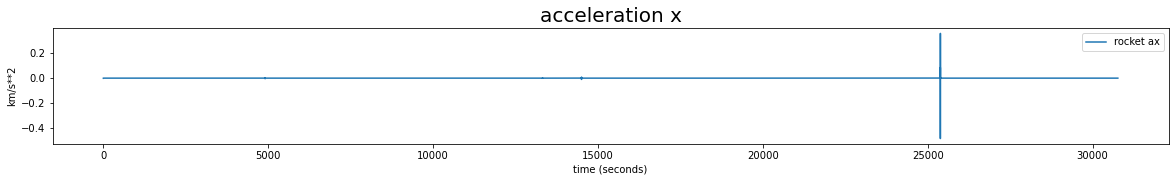

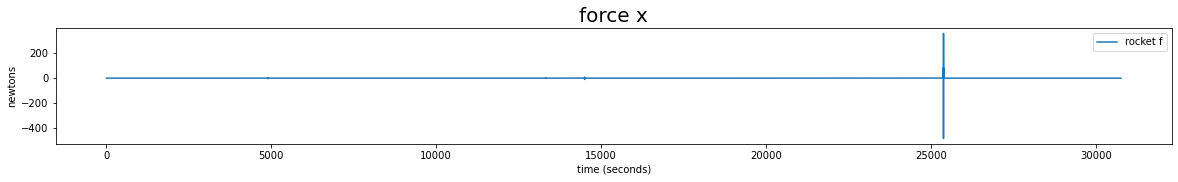

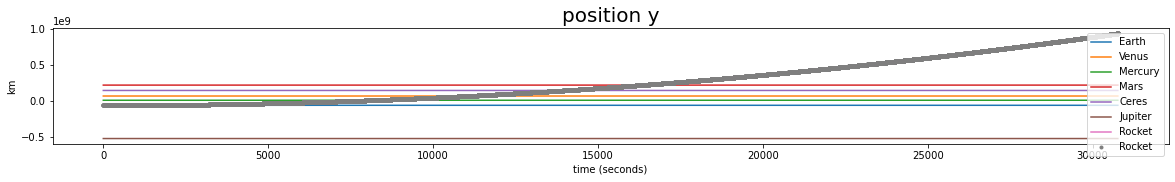

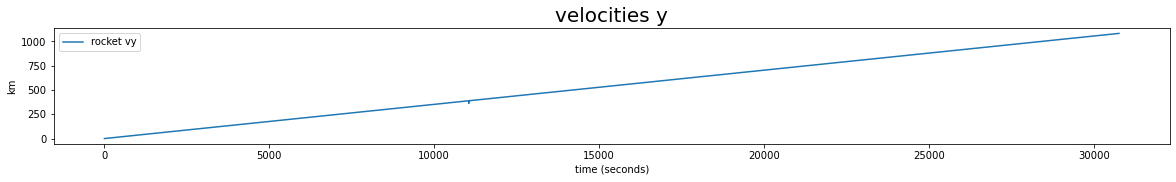

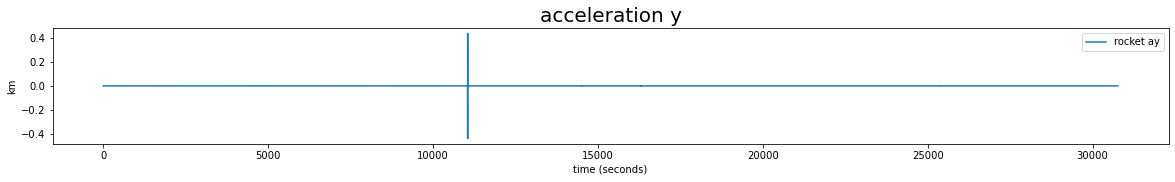

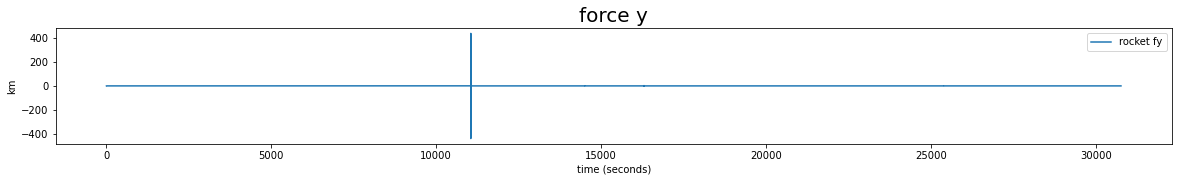

In [10]:
#PLOTTING
'''SETTING SOME PARAMETERS'''
w = 20
fs= 20

'''X PLOTS'''
plt.figure(figsize=(20,w))
plt.subplot(8,1,1)
plt.title('position x', fontsize=20)
for i,x in enumerate(px,0):
    plt.plot(x[1:], label=names[i])
plt.xlabel('time (seconds)')    
plt.ylabel('km')
plt.legend();
    
plt.figure(figsize=(20,w))
plt.subplot(8,1,2)
plt.title('velocities x', fontsize=20)
plt.plot(vx_rocket, label='rocket vx')
plt.xlabel('time (seconds)')    
plt.ylabel('km/s')
plt.legend(); 

plt.figure(figsize=(20,w))
plt.subplot(8,1,3)
plt.title('acceleration x', fontsize=20)
plt.plot(ax_rocket, label='rocket ax')
plt.xlabel('time (seconds)')    
plt.ylabel('km/s**2')
plt.legend();

plt.figure(figsize=(20,w))
plt.subplot(8,1,4)
plt.title('force x', fontsize=20)
plt.plot(fx_rocket, label='rocket f')
plt.xlabel('time (seconds)')    
plt.ylabel('newtons')
plt.legend();

'''Y PLOTS'''
plt.figure(figsize=(20,w))
plt.subplot(8,1,5)
plt.title('position y', fontsize=20)
for i,y in enumerate(py,0):
    plt.plot(y[1:], label=names[i])
    if i==len(names)-1:
        plt.plot(y[1:], '.',label=names[i])
plt.xlabel('time (seconds)')    
plt.ylabel('km')
plt.legend();
    
plt.figure(figsize=(20,w))
plt.subplot(8,1,6)
plt.title('velocities y', fontsize=20)
plt.plot(vy_rocket, label='rocket vy')
plt.xlabel('time (seconds)')    
plt.ylabel('km')
plt.legend();

plt.figure(figsize=(20,w))
plt.subplot(8,1,7)
plt.title('acceleration y', fontsize=20)
plt.plot(ay_rocket, label='rocket ay')
plt.xlabel('time (seconds)')    
plt.ylabel('km')
plt.legend();

plt.figure(figsize=(20,w))
plt.subplot(8,1,8)
plt.title('force y', fontsize=20)
plt.plot(fy_rocket, label='rocket fy')
plt.xlabel('time (seconds)')
plt.ylabel('km')
plt.legend();

In [ ]:
plt.figure(figsize=(10,10))
plt.title('position ', fontsize=25)
for i,x in enumerate(px,0):
    markersize = 1000
    if i == len(names):
        markersize=4
    plt.plot(x[1:],py[i][:-1], label=names[i], markersize=markersize)
plt.xlabel('km', fontsize=20)    
plt.ylabel('km', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

#make the other planets larger
plt.figure(figsize=(10,10))
plt.title('Distance')
plt.plot(d_store)
#plt.ylim((0,d_store[0]));

### PLOTTING FOR PROGRESS REPORT 3

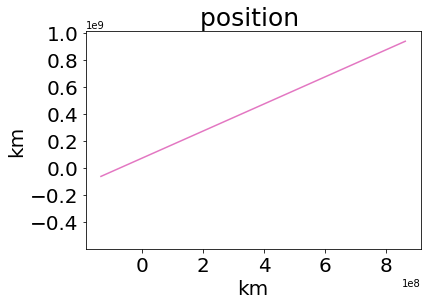

In [22]:
#X VS Y WITH DESTINATION HIGHLITED

#plt.figure(figsize=(10,10))
plt.title('position ', fontsize=25)
for i,x in enumerate(px,0):
    markersize = 1000
    if i == len(names):
        markersize=4
    plt.plot(x[1:],py[i][:-1], label=names[i], markersize=markersize)
plt.xlabel('km', fontsize=20)    
plt.ylabel('km', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
#plt.legend(fontsize=20);




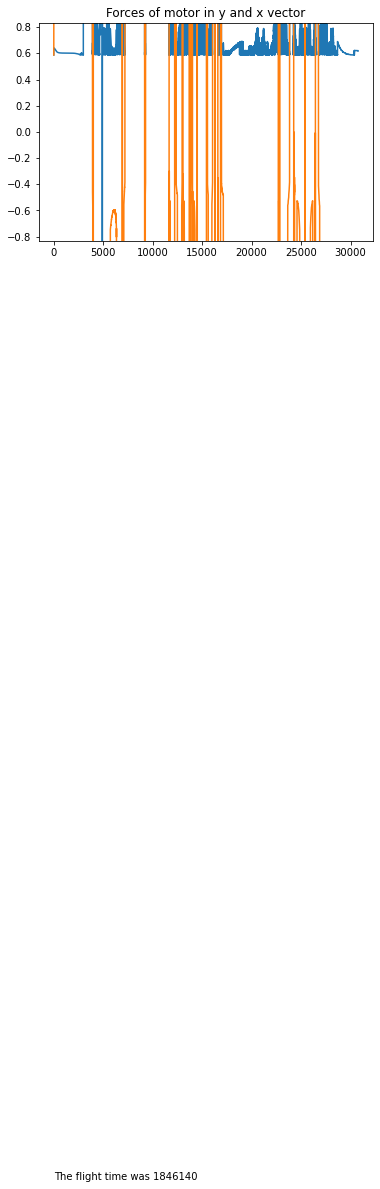

In [20]:
t = np.linspace(0,len(fx_motor),len(fx_motor))
plt.title('Forces of motor in y and x vector')
plt.plot(t,fx_motor, label='fx vector of motor')
plt.plot(t,fy_motor, label='fy vector of motor')
plt.text(12,-8,'The flight time was 1846140')
plt.ylim(-F,F);


In [ ]:
#FORCE ROCKET MOTORS VS TIME WITH K TAU PRINTED

plt.figure(figsize=(100,100))




plt.legend();